In [92]:
import copy

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
import numpy as np
import pickle
from PIL import Image
import seaborn as sns
import torch

from rlpyt.envs.gym import make as gym_make
from rlpyt.models.dqn.grid_dsr_model import GridDsrModel, GridDsrSmallModel, GridDsrCompactModel, GridDsrRandomModel

In [36]:
def load_model(param_file, env, mode='full', device=torch.device('cpu')):
    params = torch.load(param_file, map_location=device)
    if mode == 'full':
        model = GridDsrModel(env.observation_space.shape, env.action_space.n)
    elif mode == 'small':
        model = GridDsrSmallModel(env.observation_space.shape, 4)
    elif mode == 'compact':
        model = GridDsrCompactModel(env.observation_space.shape, env.action_space.n)
    elif mode == 'random':
        model = GridDsrRandomModel(env.observation_space.shape, env.action_space.n)
    model_params = params['agent_state_dict']['model']
    model.load_state_dict(model_params)
    return model

In [57]:
def get_dsr(obs, model, device=torch.device('cpu')):
    features = model(torch.Tensor(obs).unsqueeze(0).to(device))
    return model(features, mode='dsr')

### DSR

In [59]:
with open('../experiments/successor-data/20191109-run4-20k.pkl', 'rb') as handle:
    DSR = pickle.load(handle)

##### Visualize differences in successor features for consecutive coordinates

In [82]:
xDSR = {}
yDSR = {}

In [83]:
with torch.no_grad():
    for pos, sf in DSR.items():
        x, y = pos
        if x in xDSR:
            xDSR[x][0] += sf
            xDSR[x][1] += 1
        else:
            xDSR[x] = [sf, 1]
        if y in yDSR:
            yDSR[y][0] += sf
            yDSR[y][1] += 1
        else:
            yDSR[y] = [sf, 1]
    for x, data in xDSR.items():
        xDSR[x] = data[0] / data[1]
    for y, data in yDSR.items():
        yDSR[y] = data[0] / data[1]

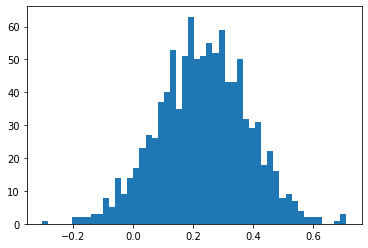

In [114]:
fig = plt.hist(xDSR[12] - xDSR[11], bins=50)

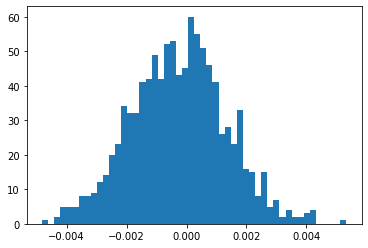

In [113]:
fig = plt.hist(xDSR[11] - xDSR[10], bins=50)

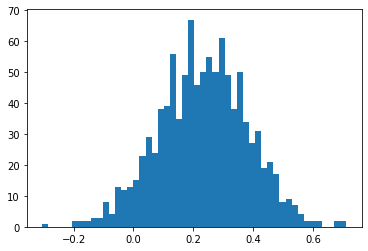

In [115]:
fig = plt.hist(yDSR[6] - xDSR[5], bins=50)

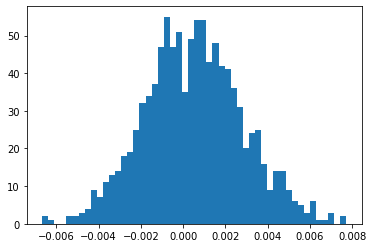

In [116]:
fig = plt.hist(yDSR[5] - xDSR[4], bins=50)

##### Visualize varying x

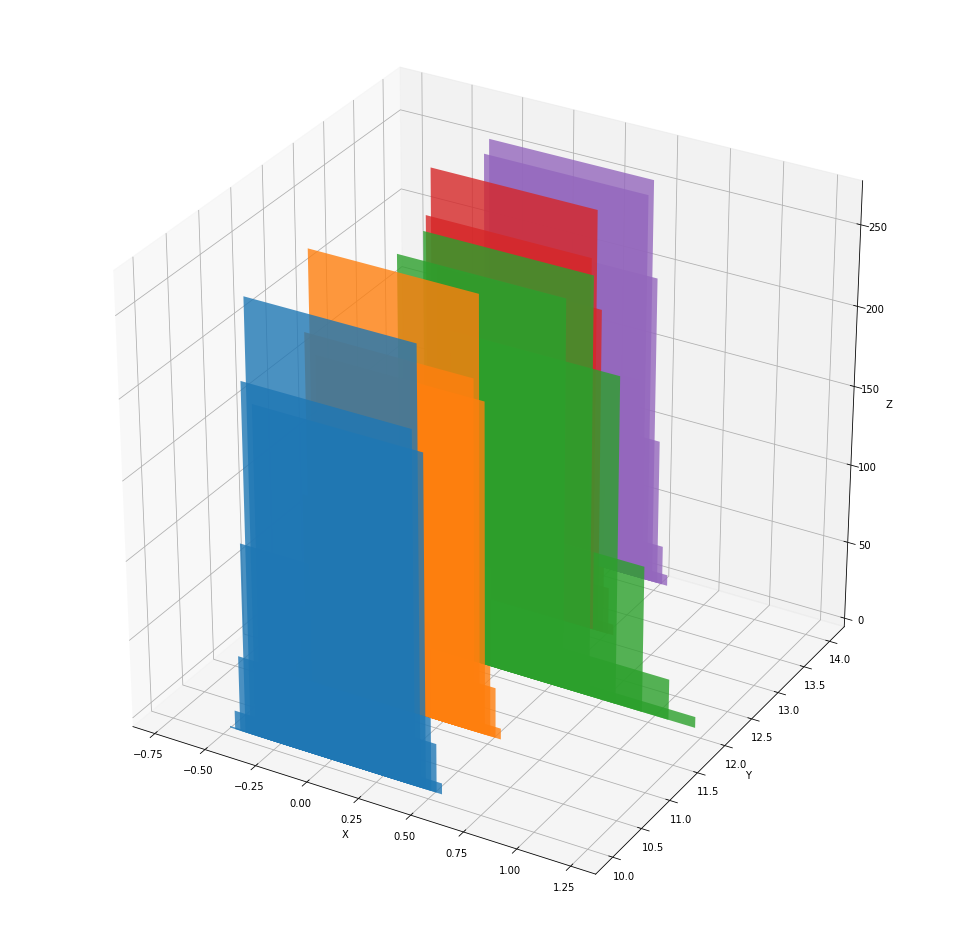

In [101]:
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(111, projection='3d')
# for z in sorted(xDSR.keys()):
for z in range(10, 15):
    ys = xDSR[z]

    hist, bins = np.histogram(ys)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

##### Visualize varying y

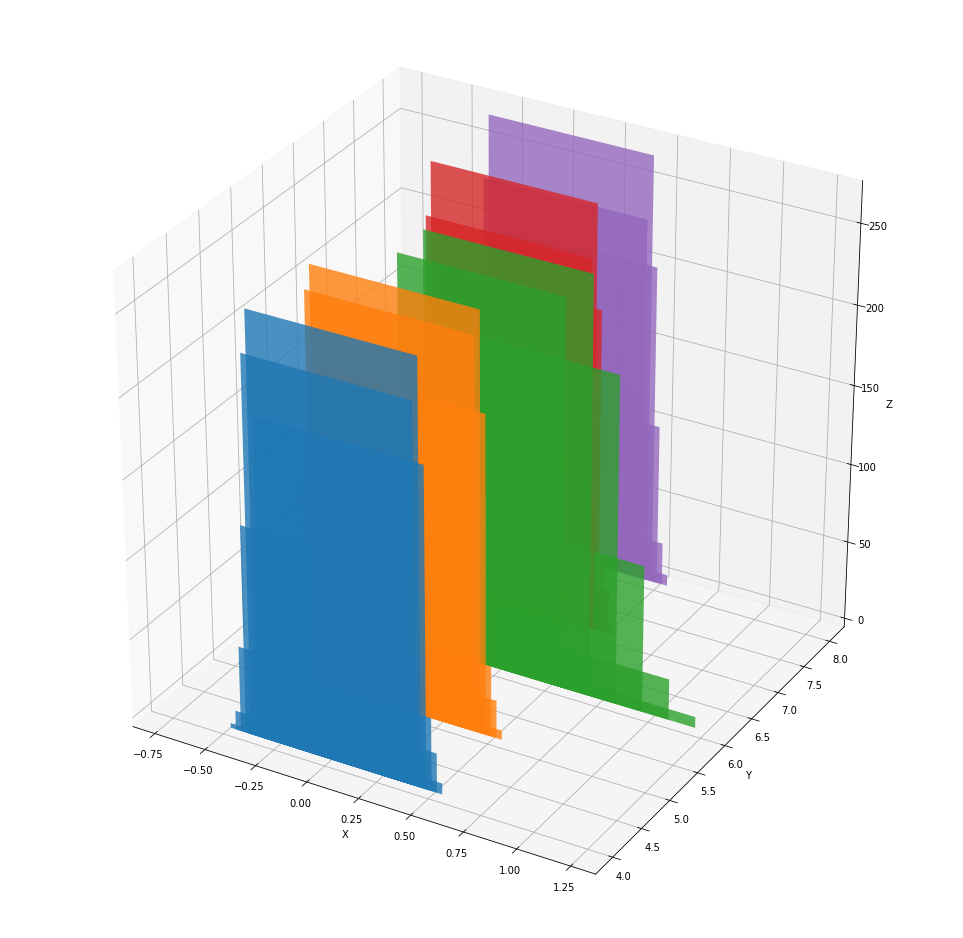

In [98]:
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(111, projection='3d')
nbins = 50
# for z in sorted(yDSR.keys()):
for z in range(4, 9):
    ys = yDSR[z]

    hist, bins = np.histogram(ys)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='y', alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [38]:
env_id = 'MiniGrid-FourRooms-v0'
mode = 'random'
minigrid_config = {'mode': mode}
env = gym_make(id=env_id, minigrid_config=minigrid_config)

In [39]:
model = load_model('../experiments/trained-models/20191109-run4.pkl', env, mode=mode)

### Reconstruction

In [127]:
env_id = 'MiniGrid-FourRooms-v0'
mode = 'small'
minigrid_config = {'mode': mode}
env = gym_make(id=env_id, minigrid_config=minigrid_config)

In [129]:
model = load_model('../experiments/trained-models/20191119-run4.pkl', env, mode=mode)

##### First layer filters visualized as images

In [141]:
first_layer = model.encoder[0].weight

In [173]:
images = []

In [174]:
for f in first_layer:
    f_np = f.permute(1, 2, 0).detach().numpy()
    f_np = np.interp(f_np, (f_np.min(), f_np.max()), (0, 255))
    image = Image.fromarray(f_np, 'RGB').resize((60, 60), Image.NEAREST)
    images.append(image)

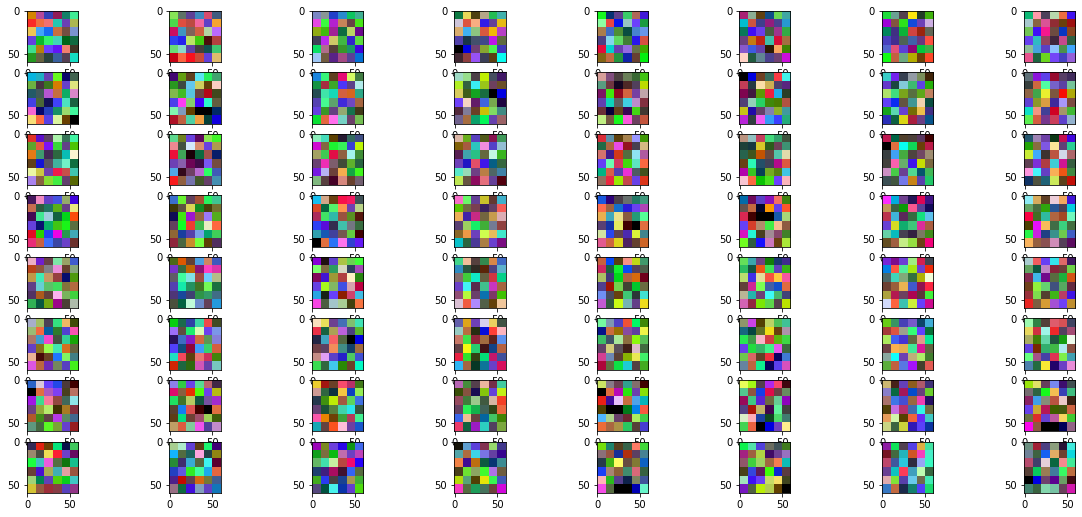

In [180]:
plt.figure(figsize=(20,10))
columns = 8
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

##### Image embedding feature vectors

In [226]:
_ = env.reset()

In [227]:
positions = np.array(list(DSR.keys()))

In [240]:
features = []
for pos in positions:
    env.unwrapped.agent_pos = pos
    obs, _, _, _ = env.step(0)
    obs = torch.Tensor(obs).unsqueeze(0) / 255
    f = model(obs).squeeze(0).detach().numpy()
    features.append(f)
features = np.stack(features)

In [241]:
from sklearn.decomposition import PCA

In [251]:
pca = PCA(n_components=2)

In [272]:
reduced = pca.fit_transform(features)
pca.explained_variance_ratio_

array([0.18909833, 0.10134037], dtype=float32)

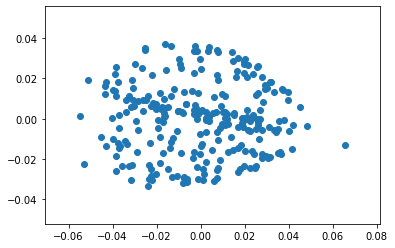

In [255]:
plt.scatter(reduced[:, 0], reduced[:, 1])

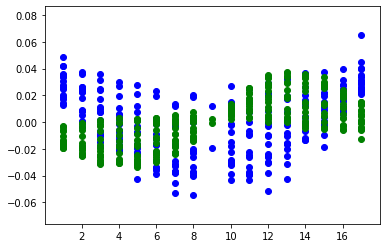

In [270]:
plt.scatter(positions[:, 0], reduced[:, 0], color='blue')
plt.scatter(positions[:, 0], reduced[:, 1], color='green')

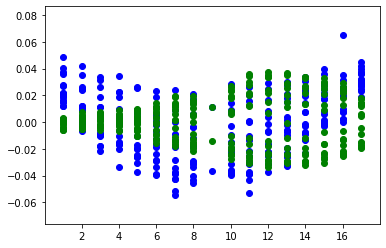

In [271]:
plt.scatter(positions[:, 1], reduced[:, 0], color='blue')
plt.scatter(positions[:, 1], reduced[:, 1], color='green')